# PetFinder.my Pawpularity Score / Train

## Imports

In [1]:
# Imports
import os
import numpy as np
from IPython.display import display

# Import landmark recognition lib
import petfinder_pawpularity_lib as mllib
tf_strategy = mllib.tf_strategy()

'TensorFlow Version: 2.6.0'

'TensorFlow Strategy: _DefaultDistributionStrategy'

In [2]:
# Enable retina display
%config InlineBackend.figure_format = "retina"

# Load Tensorboard
%load_ext tensorboard

## Settings

### Settings definitions

In [3]:
# Settings Map
if "settingsMap" not in globals(): settingsMap = {}

In [4]:
# train-local-cut
settingsMap["train-local-cut"] = {
    "debug": False,
    "model_load_dir": os.path.join("models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("dataset-copy"),
    "dataset_batch_size": 32,
    "dataset_image_size": (150, 150),
    "dataset_cut_ratio": 0.2,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.7, 0.2, 0.1],
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "train_save_checkpoint_flag": False,
    "train_fine_tuning_flag": False,
    "train_load_model_flag": True,
    "infer_load_model_flag": False,
    "synchronize_models_flag": True,
    "train_max_epochs": 10,
    "train_early_stopping": 3,
    "cleanup_data_flag": False,
}

In [5]:
# train-local-cut
settingsMap["train-local-full"] = {
    "debug": True,
    "model_load_dir": os.path.join("models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("dataset-copy"),
    "dataset_batch_size": 64,
    "dataset_image_size": (150, 150),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.7, 0.2, 0.1],
    "dataset_shuffle": True,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "train_save_checkpoint_flag": False,
    "train_fine_tuning_flag": False,
    "train_load_model_flag": True,
    "infer_load_model_flag": False,
    "synchronize_models_flag": True,
    "train_max_epochs": 1,
    "train_early_stopping": 3,
    "cleanup_data_flag": False,
}

In [6]:
# train-remote-cut
settingsMap["train-remote-cut"] = {
    "debug": False,
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-train", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("dataset", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("dataset-copy"),
    "dataset_batch_size": 64,
    "dataset_image_size": (500, 500),
    "dataset_cut_ratio": 0.2,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.7, 0.2, 0.1],
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "train_save_checkpoint_flag": False,
    "train_fine_tuning_flag": False,
    "train_load_model_flag": True,
    "infer_load_model_flag": False,
    "synchronize_models_flag": True,
    "train_max_epochs": 10,
    "train_early_stopping": 2,
    "cleanup_data_flag": True,
}

In [7]:
# train-remote-full
settingsMap["train-remote-full"] = {
    "debug": False,
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-train", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("dataset", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("dataset-copy"),
    "dataset_batch_size": 64,
    "dataset_image_size": (750, 750),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.90, 0.05, 0.05],
    "dataset_shuffle": True,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "train_save_checkpoint_flag": False,
    "train_fine_tuning_flag": False,
    "train_load_model_flag": True,
    "infer_load_model_flag": False,
    "synchronize_models_flag": True,
    "train_max_epochs": 25,
    "train_early_stopping": 5,
    "cleanup_data_flag": True,
}

In [8]:
# train-remote-full-empty
settingsMap["train-remote-full-empty"] = {
    "debug": False,
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-empty", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("dataset", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("dataset-copy"),
    "dataset_batch_size": 64,
    "dataset_image_size": (750, 750),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.90, 0.05, 0.05],
    "dataset_shuffle": True,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "train_save_checkpoint_flag": False,
    "train_fine_tuning_flag": False,
    "train_load_model_flag": True,
    "infer_load_model_flag": False,
    "synchronize_models_flag": True,
    "train_max_epochs": 1,
    "train_early_stopping": 3,
    "cleanup_data_flag": True,
}

### Selected settings

In [9]:
# Mode
mode = "train-local-full"

In [10]:
# Selected settings
settings = settingsMap[mode]
display(settings)

# Debug
debug = settings["debug"]

{'debug': True,
 'model_load_dir': 'models',
 'model_save_dir': 'models',
 'dataset_dir_src': '../input/petfinder-pawpularity-score',
 'dataset_dir_cut': '../input/petfinder-pawpularity-score',
 'dataset_dir_copy': 'dataset-copy',
 'dataset_batch_size': 64,
 'dataset_image_size': (150, 150),
 'dataset_cut_ratio': 1.0,
 'dataset_shrink_ratio': 1.0,
 'dataset_split_ratios': [0.7, 0.2, 0.1],
 'dataset_shuffle': True,
 'dataset_shuffle_seed': 42,
 'dataset_prefetch': -1,
 'train_save_checkpoint_flag': False,
 'train_fine_tuning_flag': False,
 'train_load_model_flag': True,
 'infer_load_model_flag': False,
 'synchronize_models_flag': True,
 'train_max_epochs': 1,
 'train_early_stopping': 3,
 'cleanup_data_flag': False}

## Prepare data

'../input/petfinder-pawpularity-score'

'Copy ../input/petfinder-pawpularity-score/train.csv to dataset-copy/train.csv'

'Load training data from ../input/petfinder-pawpularity-score/train.csv'

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


Train / Validate / Test datasets items: 6912 / 1984 / 960

Train dataset:
Cause: could not parse the source code of <function <lambda> at 0x7f90e0149160>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f90e0149160>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


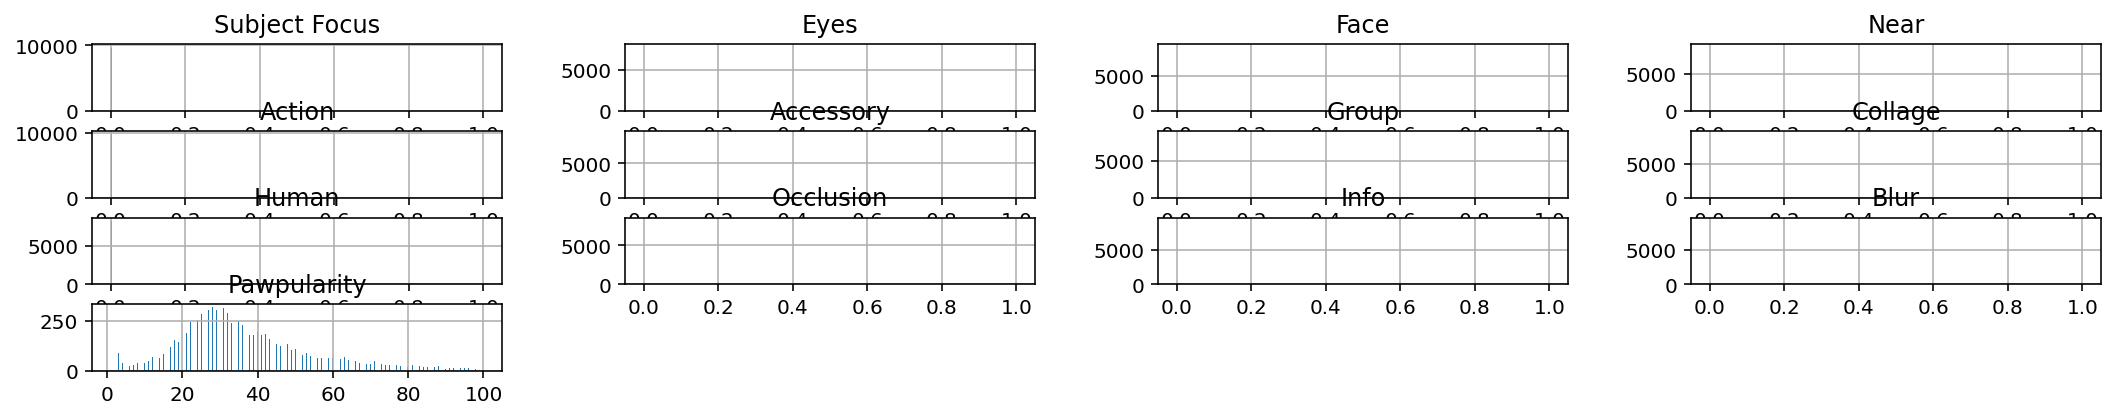

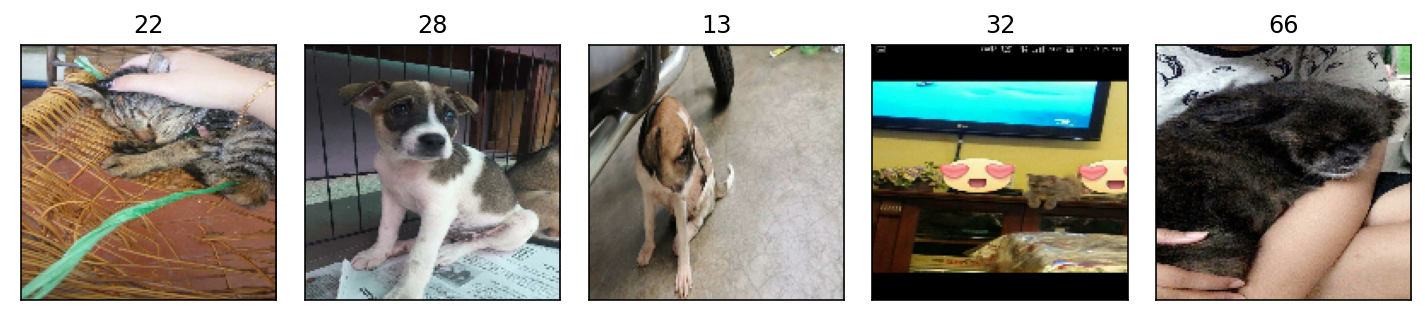

Validate dataset:


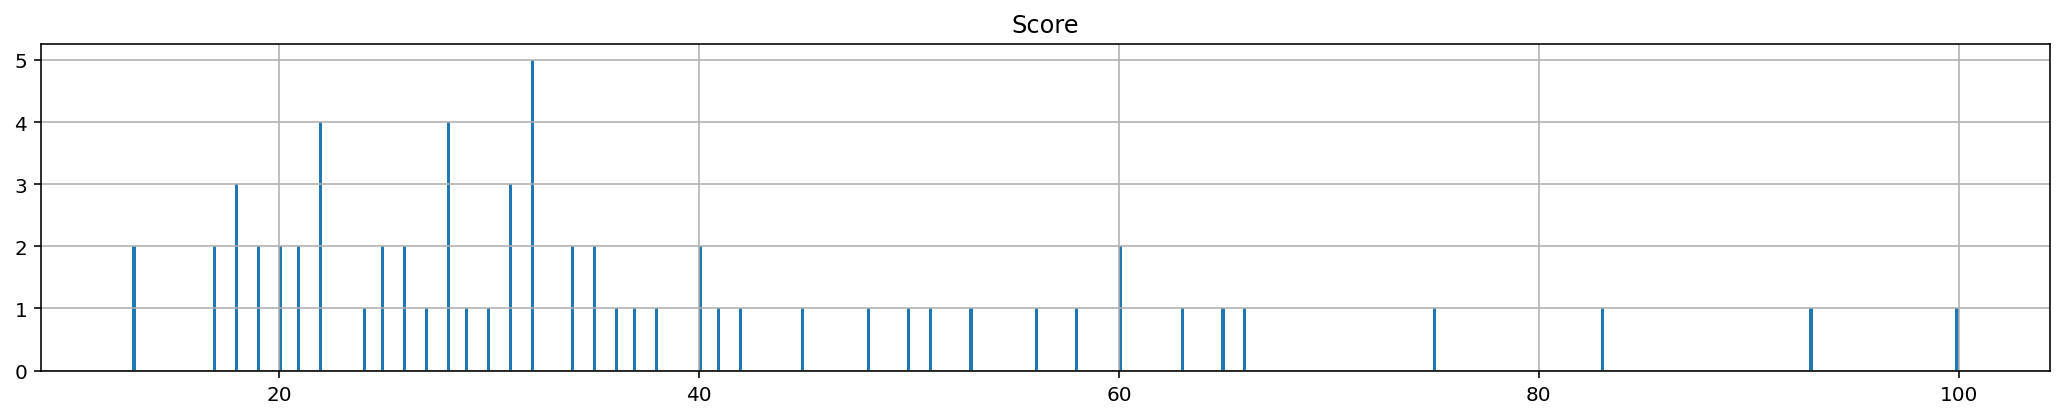

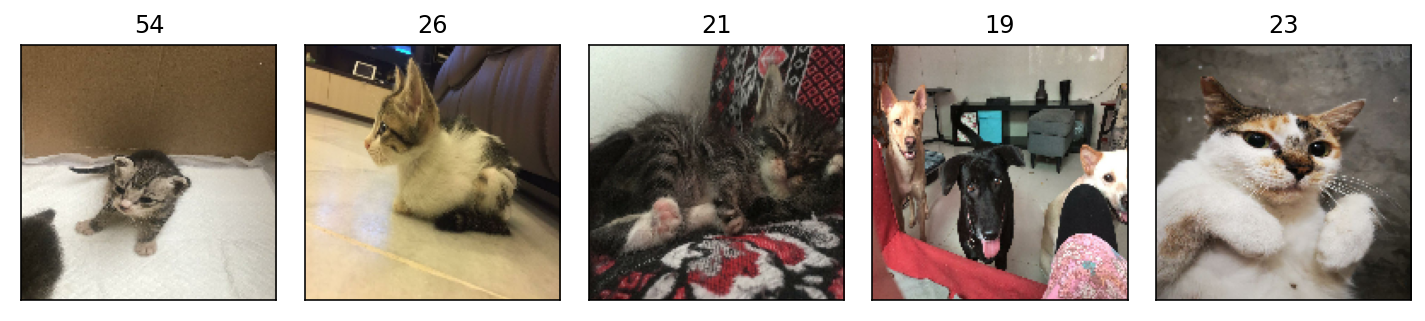

Test dataset:


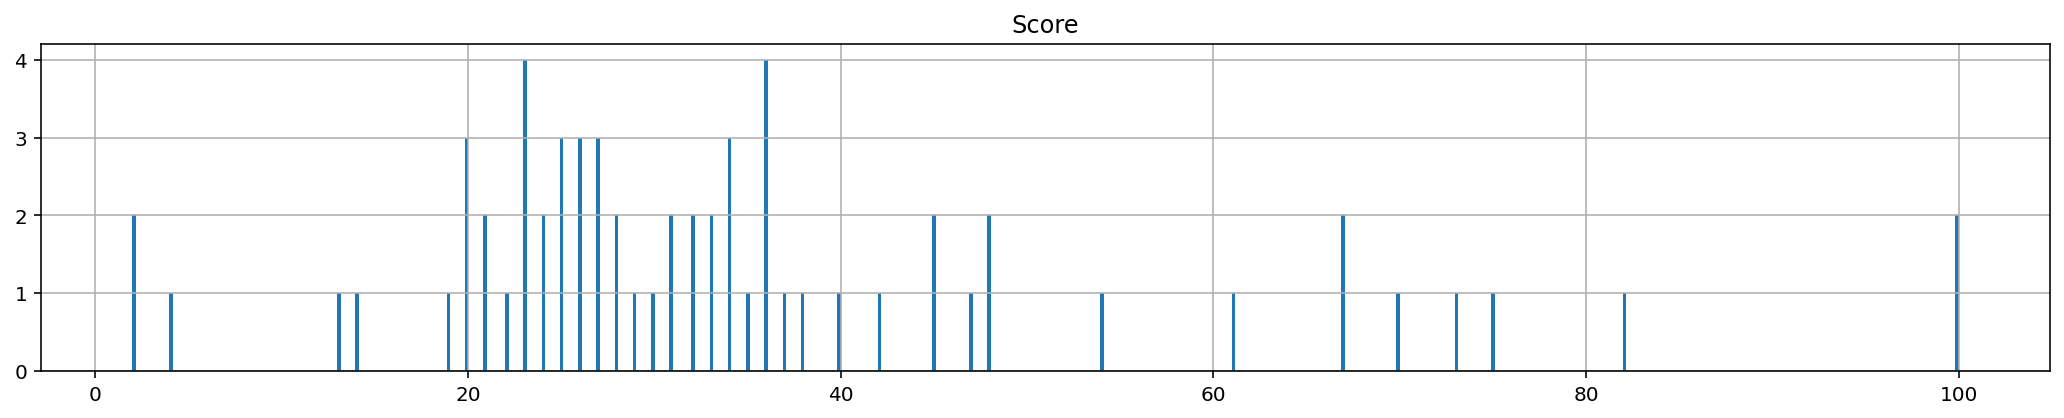

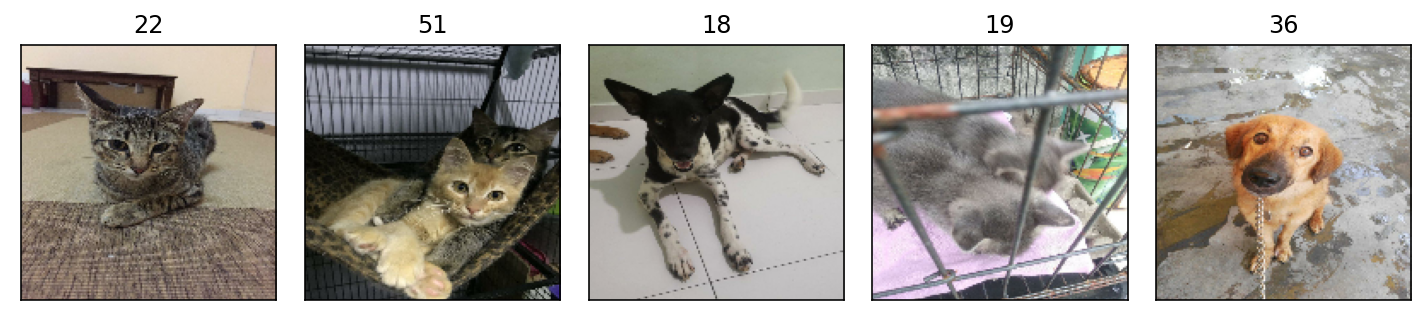

CPU times: user 22.6 s, sys: 3.16 s, total: 25.8 s
Wall time: 19.9 s


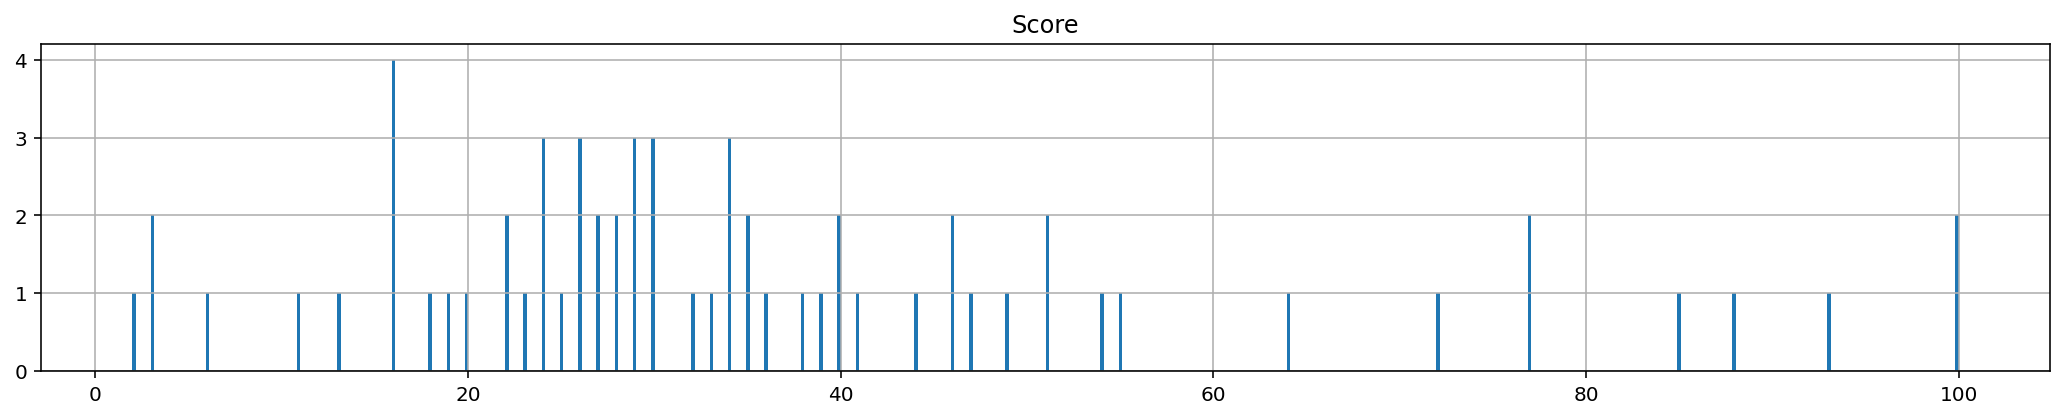

In [11]:
%%time
# Cut training data
dataset_dir = mllib.cut_training_data(
    cut_ratio=settings["dataset_cut_ratio"], 
    dataset_dir_src=settings["dataset_dir_src"], 
    dataset_dir_cut=settings["dataset_dir_cut"]
)
display(dataset_dir)

# Copy train.csv to output (It may be different with submission dataset)
if settings["dataset_dir_copy"] is not None:
    mllib.copy_file(os.path.join(dataset_dir, "train.csv"), os.path.join(settings["dataset_dir_copy"], "train%s.csv" % mllib.cut_suffix(settings["dataset_cut_ratio"])))

# Train data
training_data = mllib.load_training_data(dataset_dir)
if debug: 
    display(training_data)
    training_data.hist(bins=500, figsize=(18,3))

# Make training data
map_image_score_fn = lambda image, features, score, file_id: (image, score)  
train_dataset, validate_dataset, test_dataset = mllib.make_training_validate_test_data(
    dataset=mllib.load_training_dataset(
        dataset_dir=dataset_dir,
        mapping_data=training_data,
        batch_size=settings["dataset_batch_size"],
        shuffle=settings["dataset_shuffle"],
        seed=settings["dataset_shuffle_seed"],
        image_size=settings["dataset_image_size"],
    ),
    split_ratios=settings["dataset_split_ratios"],
    shrink_ratio=settings["dataset_shrink_ratio"],
    prefetch=settings["dataset_prefetch"],
)
 
# Training data infos
print("Train / Validate / Test datasets items: %s / %s / %s" % (
    settings["dataset_batch_size"] * train_dataset().cardinality().numpy(), 
    settings["dataset_batch_size"] * validate_dataset().cardinality().numpy(), 
    settings["dataset_batch_size"] * test_dataset().cardinality().numpy()
))
if debug:
    print("")
    print("Train dataset:")
    mllib.plot_images_scores_from_dataset(train_dataset().take(1).map(map_image_score_fn))
    print("Validate dataset:")
    mllib.plot_images_scores_from_dataset(validate_dataset().take(1).map(map_image_score_fn))
    print("Test dataset:")
    mllib.plot_images_scores_from_dataset(test_dataset().take(1).map(map_image_score_fn))

## Synchronize models

In [12]:
%%time
# Synchronize models from load to save directories
if settings["synchronize_models_flag"]:
    synchronized_models = mllib.synchronize_models(
        model_load_dir=settings["model_load_dir"], 
        model_save_dir=settings["model_save_dir"]
    )
    display(synchronized_models)

[]

CPU times: user 1.88 ms, sys: 1.14 ms, total: 3.02 ms
Wall time: 2.23 ms


## Train model

In [13]:
# Prepare model parameters
def get_model_parameters(settings):
    dataset_image_size = settings["dataset_image_size"]
    model_parameters = {
        "model_prefix": "model" + mllib.cut_suffix(settings["dataset_cut_ratio"]),
        "model_base": "xception",
        "input_shape": [dataset_image_size[0], dataset_image_size[1], 3],
        "input_shape_features": len(mllib.feature_fields),
        "output_size": 1,
        "dropout_rate": 0.3,
        "learning_rate": 5e-4,
        "dense_layers": "100",
        "dense_layers_activation": "elu",
        "early_stopping_patience": settings["train_early_stopping"],
        "save_checkpoint": settings["train_save_checkpoint_flag"],
        "epoch": settings["train_max_epochs"],
        "fine_tuning": settings["train_fine_tuning_flag"],
    }
    model_name = mllib.get_model_name(model_parameters)
    model_file = mllib.model_file_path_load(model_name, settings["model_load_dir"])
    preload_weights = None if settings["train_load_model_flag"] and os.path.exists(model_file) else "imagenet"
    model_parameters["model_name"] = model_name
    model_parameters["preload_weights"] = preload_weights
    return model_parameters
    
model_parameters = get_model_parameters(settings)
display(model_parameters)

{'model_prefix': 'model',
 'model_base': 'xception',
 'input_shape': [150, 150, 3],
 'input_shape_features': 0,
 'output_size': 1,
 'dropout_rate': 0.3,
 'learning_rate': 0.0005,
 'dense_layers': '100',
 'dense_layers_activation': 'elu',
 'early_stopping_patience': 3,
 'save_checkpoint': False,
 'epoch': 1,
 'fine_tuning': False,
 'model_name': 'model-xception-input-150x150x3-dense-100-dropout-0.300',
 'preload_weights': 'imagenet'}

Model: "model-xception-input-150x150x3-dense-100-dropout-0.300"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 150, 150, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
tf.math.subtract (TFOpLambda)   (None, 150, 150, 3)  0           tf.math.truediv[0][0]            
__________________________________________________________________________________________________
xception (Functional)           (None, 5, 5, 2048)   20861480    tf.math.subtract[0][0]           
_____________________________________________

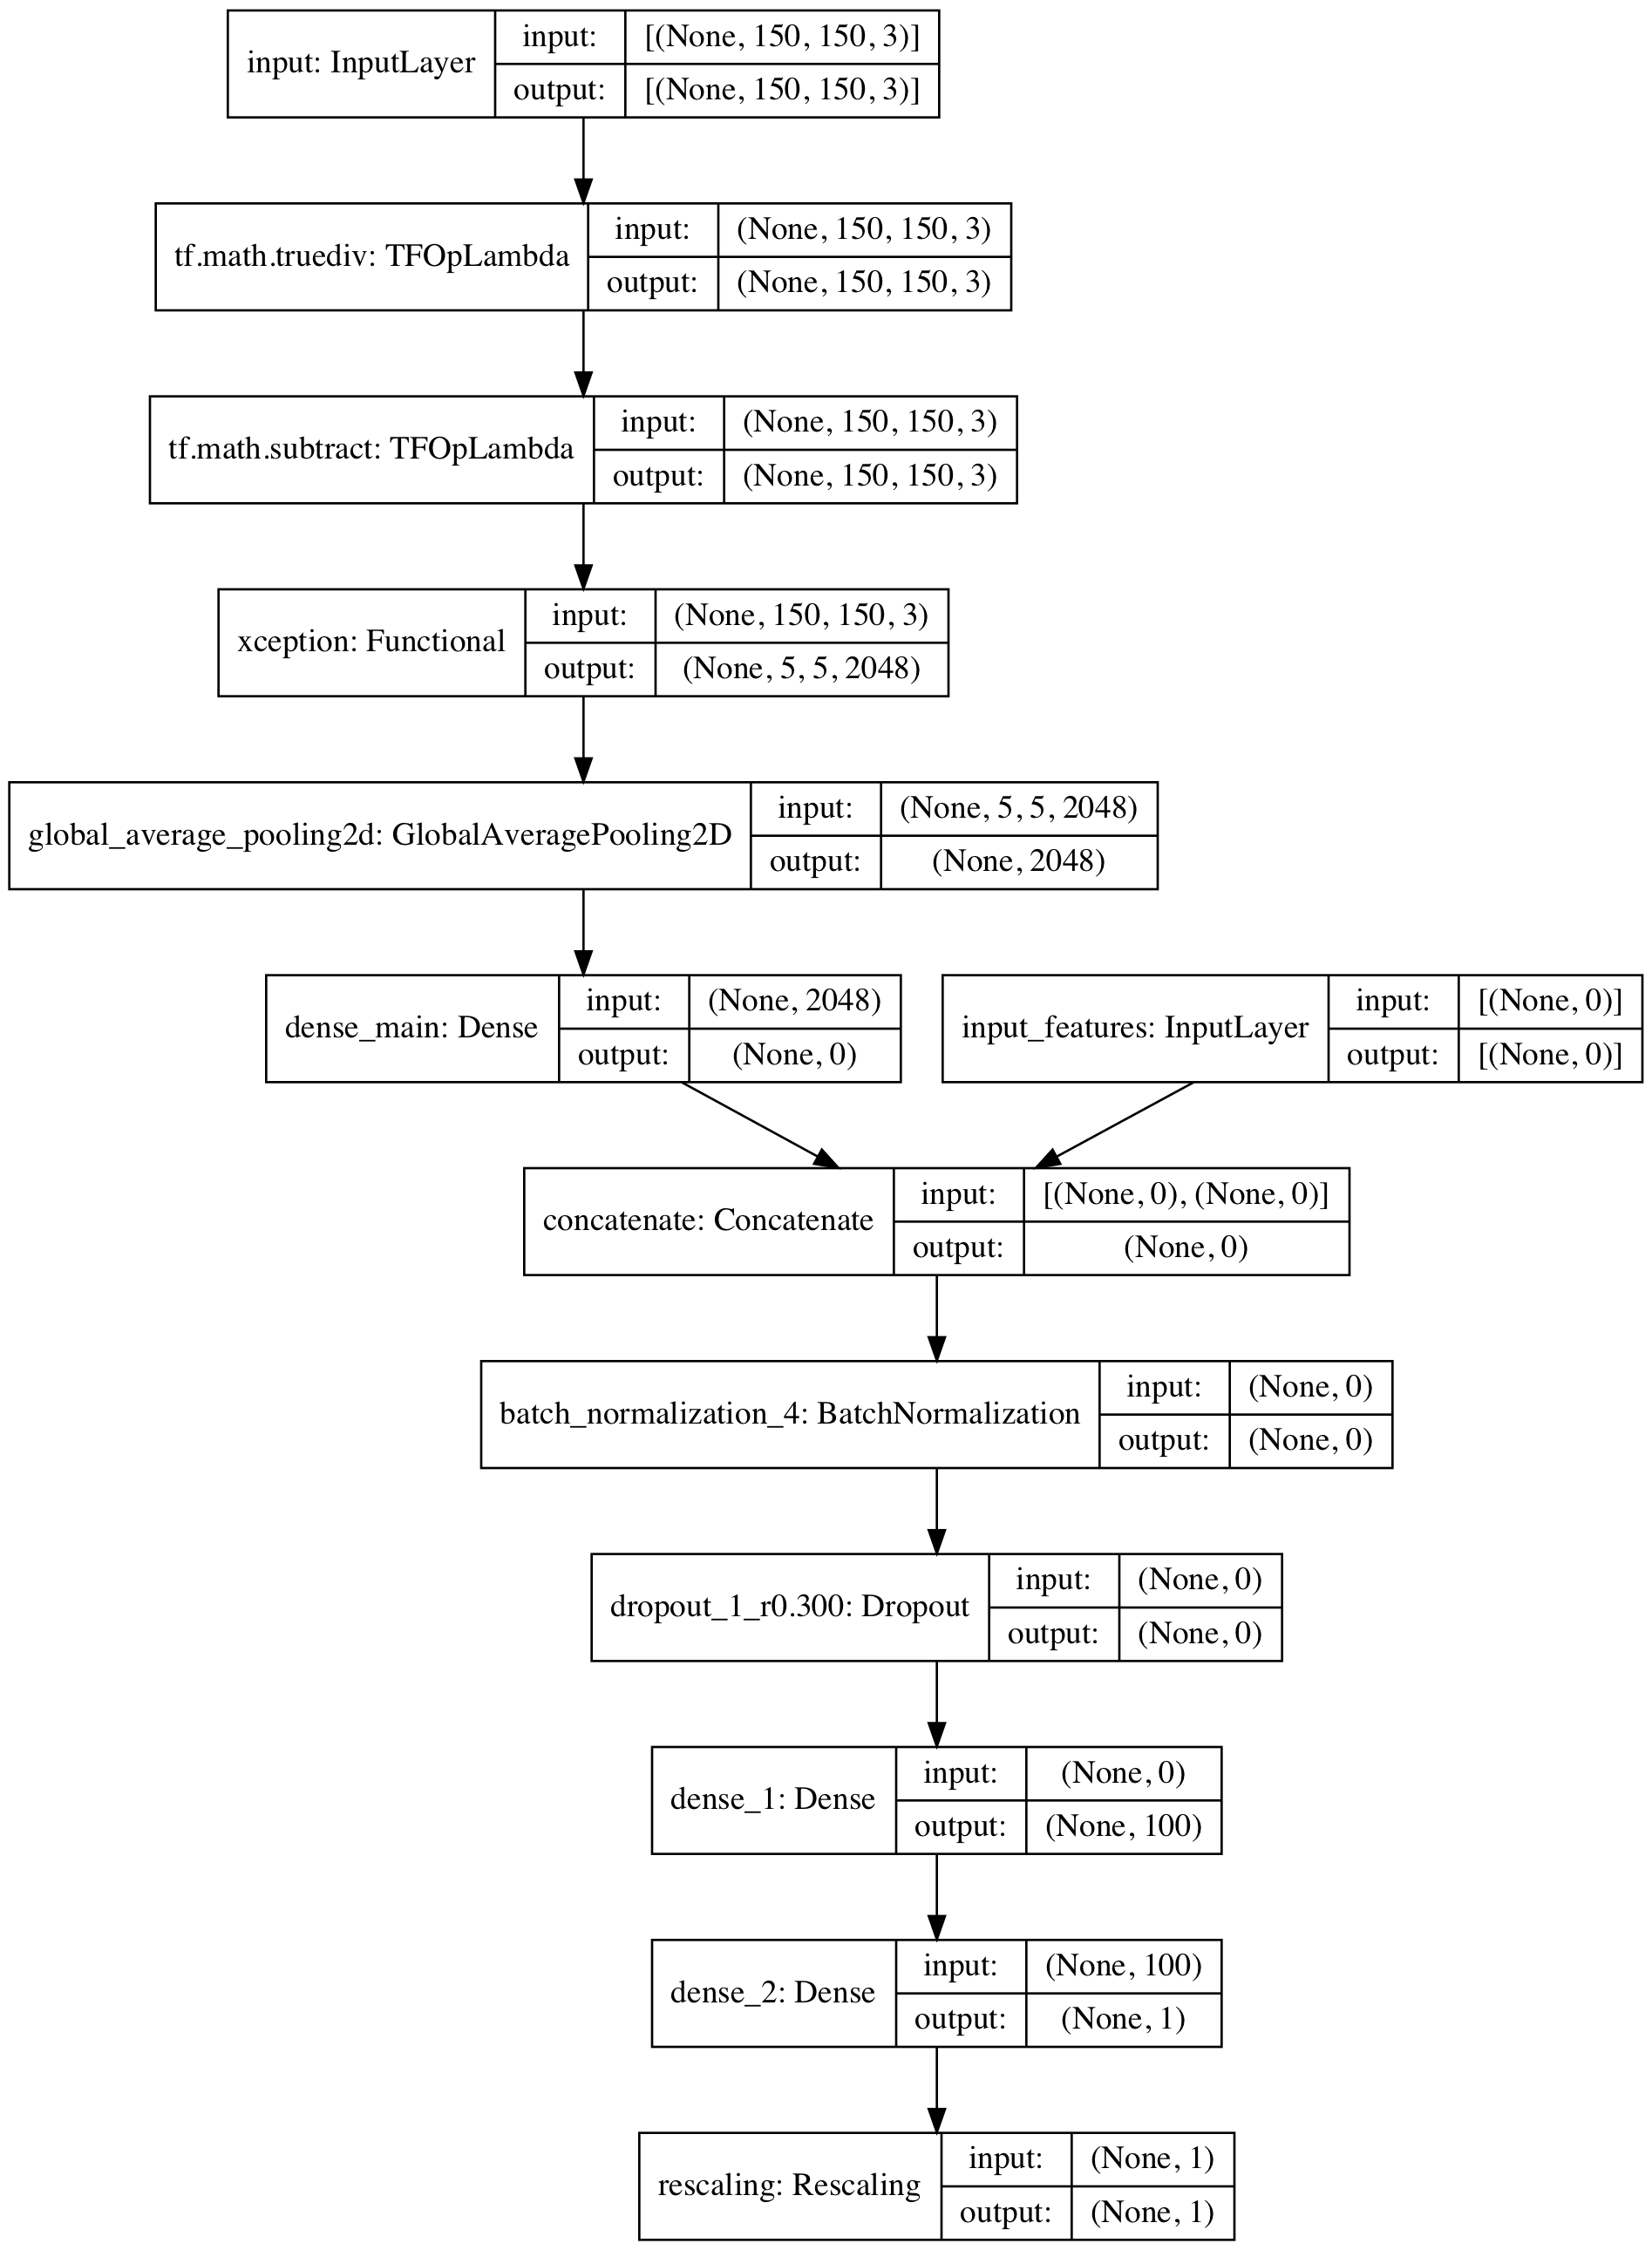

Loaded Weights: None


InvalidArgumentError:  Incompatible shapes: [64,12] vs. [1,0]
	 [[node gradient_tape/model-xception-input-150x150x3-dense-100-dropout-0.300/batch_normalization_4/moments/BroadcastGradientArgs (defined at /Users/jp/Desktop/IA/notebook/kaggle/petfinder-pawpularity/petfinder_pawpularity_lib.py:481) ]] [Op:__inference_train_function_12826]

Function call stack:
train_function


In [14]:
%%time
# Train and evaluate model
with tf_strategy.scope():
    model = mllib.setup_model(model_parameters)
    if debug:
        mllib.show_model(model, settings["model_save_dir"])
    model_file = mllib.load_model(model, settings["model_load_dir"])
    print("Loaded Weights: %s" % model_file)
    history = mllib.train_model(
        model=model, 
        train_dataset=train_dataset(),
        validate_dataset=validate_dataset(), 
        parameters=model_parameters
    )
    mllib.describe_training(history)
    if not settings["train_save_checkpoint_flag"]:
        model_file = mllib.save_model(model, settings["model_save_dir"])
        print("Saved Weights:", model_file)
    print("Evaluate:")
    evaluation = mllib.evaluate_model(model, test_dataset())
    recorded_training_data = mllib.record_training_evaluate(
        model_name=model.name,
        model_file=model_file, 
        model_parameters="%s" % model_parameters, 
        history=history, 
        evaluation=evaluation,
        model_load_dir=settings["model_load_dir"],
        model_save_dir=settings["model_save_dir"],
        records_file="_train_logs.csv",
    )
    display(recorded_training_data)

## Cleanup

In [ ]:
%%time
if settings["cleanup_data_flag"]: 
    mllib.delete_training_data(cut_ratio=settings["dataset_cut_ratio"], dataset_dir_cut=settings["dataset_dir_cut"])